<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/main/Roman%20Penzov/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_fainal_03_07_23_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Подход:**
1. для каждой категории отдельно сделал вариационный автокодировщик, меньше потребуется ресурсов в colab, и в дальнейшем можно отдельно переучивать каждую категорию отдельно. Отдельно сохранял архитектуру и веса по каждому случаю.
2. далее вторая нейронка должна определить категорию одежды, к которой относится"картинка клиента" - сверточные нейронные сети на основе базовой модели VGG16.

# **ВЫВОД:**
1. надо очень детально и тщательно подготовить базу для обучения, иначе нет возможности разделять на категории. Поэтому сначала надо согласовать категрийный классифокатор с заказчиком.
2. возможно после решения с заказчиком пункта 1 по верификации базы, то все можно сделать на основе вариационного автокодировщика с label (по названиям категорий).
3. представленный вариант не оптимизирован -- можно сократить в 12-ть раз, убрав повторяемость кода по каждой категории. Это не сделано сознательно, чтобы был виден процесс.


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import zipfile

In [ ]:
# Работа с массивами

from PIL import ImageEnhance

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import MaxPooling2D, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam, Adagrad

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Для работы с файлами
import gc

# Рисование графиков в ячейках Colab
%matplotlib inline

In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/dataset_optim.zip'

# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/selector'

In [ ]:
# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# задаем размеры фото, цвет (3-и канала) и количество категорий одежды
IMG_WIDTH = 244
IMG_HEIGHT = 244
CHANELS = 3
num_classes = 12

In [ ]:
# Этот код просматривает все файлы в указанном каталоге и его подкаталогах, открывает их с помощью PIL,
# сохраняет их в другом каталоге в формате JPEG и удаляет исходные файлы.
# Если в процессе обработки файла возникает ошибка, выводится сообщение об ошибке, но обработка продолжается.
# проверка открытия файлов и сохранения в jpg - все это в новую базу по новому пути. Будем использовать неполную базу данных для быстроты эксперимента
# Это импортирует модуль re (регулярные выражения), который будет использоваться позже для работы с шаблонами
import re

path = 'selector' # путь до каталога с каталогами одежды
path_to = 'selector_new_'

pattern = '.*(?=\.)' # Здесь определяется шаблон регулярного выражения. Он используется для извлечения имени файла без расширения
dir_list = os.listdir(path)
if not os.path.isdir(path_to):
     os.mkdir(path_to)
for i in dir_list:
    if not os.path.isdir(f'{path_to}/{i}'):
        os.mkdir(f'{path_to}/{i}')
    fl = os.listdir(f'{path}/{i}')
    for i2 in fl[:1000]:   # неполная база. Если нужна полная, тогда fl[:1000] заменяем на fl
        fn = re.match(pattern, i2)
        img = f'{path}/{i}/{i2}'
        try:
            im = Image.open(img).convert("RGB") # Изображение открывается с помощью библиотеки PIL (Python Imaging Library) и преобразуется в формат RGB.
        except:
            print(f'При обработке файла {i}/{i2} произошла ошибка. Файл не читается.')
            pass
        if not os.path.isfile(f'{path_to}/{i}/{fn.group(0)}.jpg'):
            im.save(f'{path_to}/{i}/{fn.group(0)}.jpg', 'jpeg')
        else:
            im.save(f'{path_to}/{i}/{fn.group(0)}ren545.jpg', 'jpeg') # Изображение сохраняется в целевом каталоге с измененным именем, добавляя "ren545" перед расширением ".jpg".
        im.close()
        os.remove(f'{path}/{i}/{i2}')

In [ ]:
# путь к базе
data_dir = path_to
os.listdir(data_dir)
batch_size= 32
image_size= (244, 244)

In [ ]:
# Получение списка папок, находящихся по адресу в скобках
CLASS_LIST = sorted(os.listdir(data_dir))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 12, метки классов: ['dress  business', 'dress casual', 'dress homemade', 'dress solemn', 'shirt men', 'shirt women', 'sportswear men', 'sportswear women', 't-shirt men', 't-shirt women', 'trousers men', 'trousers women']


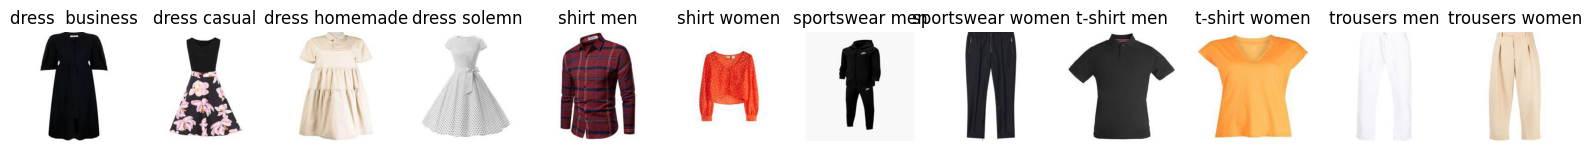

In [ ]:
# Отобразим визуально для примера по одному изображению из каждого класса
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(20,20))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{data_dir}/{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
# Загрузка и предобработка изображений из базы данных
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(
            os.path.join(folder, filename),
            target_size=(128, 128)  # Размер изображения для входа в автокодировщик
        )
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# **каждую категорию обрабатываю отдельно. В дальнейшем это даст возможность отдельного переобучения каждой категории отдельно, если заказчик захочет внести изменени только в отдельную выбранную категорию. Также так требуется меньше ресурсов процессора.**

# **dress business**

In [ ]:
# Создание списка категорий товаров
categories = ['dress  business'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_0 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_0.append(image)

# Преобразование списка в массив
X_0 = np.array(X_0)

# Нормализация данных
X_0 = X_0.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_0, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

In [ ]:
# Создание модели автокодировщика
def build_vae(input_shape, latent_dim):
    # Кодировщик
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Сэмплирование из нормального распределения с параметрами z_mean и z_log_var
    def sampling(args):
        z_mean, z_log_var = args
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

    # Декодер
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(16, activation='relu')(decoder_input)
    x = Dense(32 * 32 * 64, activation='relu')(x)
    x = Reshape((32, 32, 64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_input, x, name='decoder')

    # VAE
    vae_output = decoder(encoder(encoder_input)[2])
    vae = Model(encoder_input, vae_output, name='vae')

    return vae

In [ ]:
# Построение модели автокодировщика с заданными параметрами
vae = build_vae(input_shape=(128, 128, 3), latent_dim=50)

# Компиляция модели
vae.compile(optimizer='adam', loss='mse')

In [ ]:
# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_DB_test, resized_DB_test)
)

Epoch 1/50
20/20 [==============================] - 1s 46ms/step - loss: 0.0455 - val_loss: 0.0397
Epoch 2/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 3/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0347 - val_loss: 0.0354
Epoch 4/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0336 - val_loss: 0.0351
Epoch 5/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0327 - val_loss: 0.0343
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0322 - val_loss: 0.0340
Epoch 7/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0316 - val_loss: 0.0336
Epoch 8/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0309 - val_loss: 0.0332
Epoch 9/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0303 - val_loss: 0.0328
Epoch 10/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0297 - val_loss: 0.0329
Epoch 11/

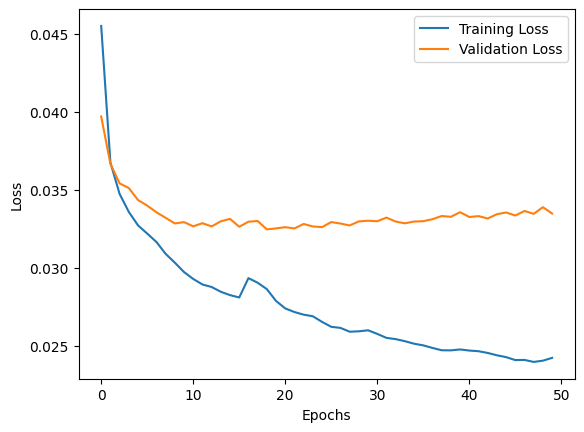

In [ ]:
# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/1 (3).jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 39ms/step


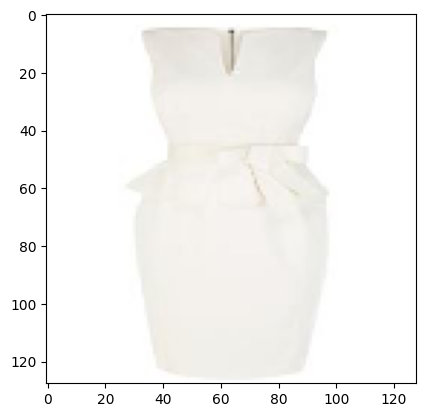

In [ ]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

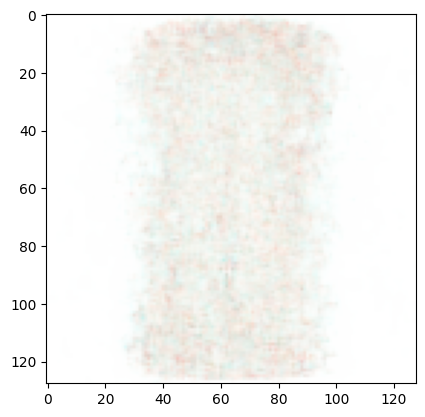

In [ ]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

In [ ]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/13.jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 22ms/step


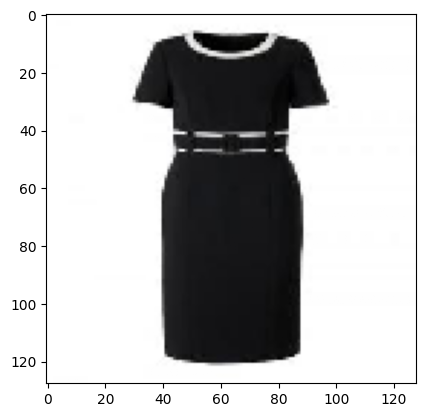

In [ ]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

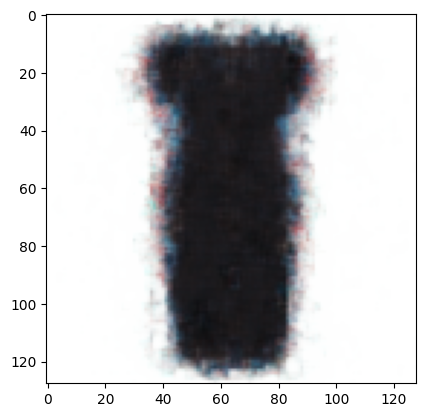

In [ ]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

In [ ]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/657 (4).jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 23ms/step


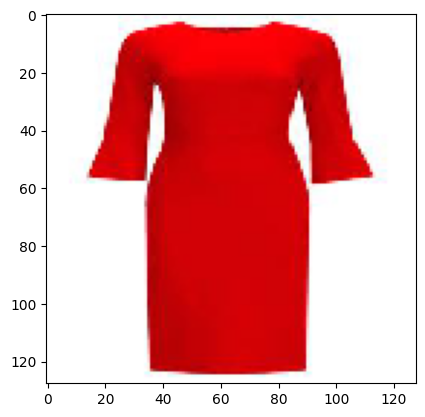

In [ ]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

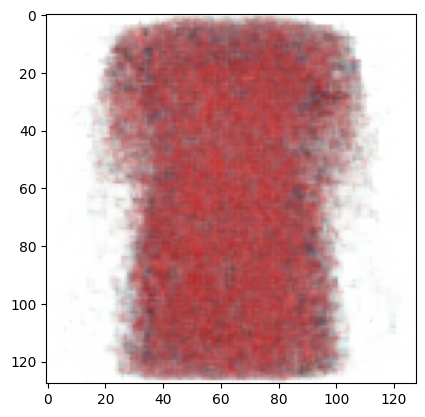

In [ ]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

In [ ]:
# NearestNeighbors из sklearn.neighbors используется для поиска ближайших соседей
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Функция для поиска схожих изображений
def find_similar_images(image_path, num_neighbors=5): # путь к изображению image_path и необязательный параметр num_neighbors (по умолчанию 5)
    # Загрузка и предобработка изображения
    test_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
    test_image = np.expand_dims(test_image, axis=0) # расширяется по размерности 0, чтобы соответствовать ожидаемой форме входных данных модели

    # Получение кодировки изображения с помощью encoder.predict, используя слой encoder модели vae.
    # Метод predict применяется к слою encoder и принимает тестовое изображение в качестве входных данных.
    # Результатом является предсказанная кодировка, из которой мы берем только z_mean (среднее значение)
    encoded_image = vae.get_layer('encoder').predict(test_image)[0]  # !!! Используем только z_mean

    # Создание экземпляра NearestNeighbors и подгонка с использованием всех кодировок обучающей выборки
    # Здесь мы создаем экземпляр класса NearestNeighbors с параметром n_neighbors,
    # указывающим количество ближайших соседей для поиска,
    # и указываем метрику 'euclidean' для вычисления расстояний между соседями.
    # Затем мы подгоняем модель nn с использованием кодировок обучающей выборки,
    # полученных с помощью слоя encoder модели vae.
    nn = NearestNeighbors(n_neighbors=num_neighbors, metric='euclidean')
    nn.fit(vae.get_layer('encoder').predict(resized_X_train)[0])  # !!! Используем только z_mean

    # Поиск ближайших соседей
    distances, indices = nn.kneighbors(encoded_image)

    # Вывод исходного изображения
    plt.imshow(test_image.reshape(128, 128, 3))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Вывод ближайших соседей
    fig, axs = plt.subplots(1, num_neighbors, figsize=(20, 20))

    for i, index in enumerate(indices[0]):
        similar_image = resized_X_train[index].reshape(128, 128, 3)
        axs[i].imshow(similar_image)
        axs[i].set_title(f'Similar Image {i+1}')
        axs[i].axis('off')

    plt.show()

20/20 [==============================] - 0s 4ms/step


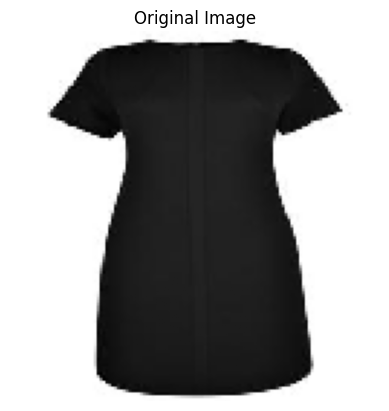

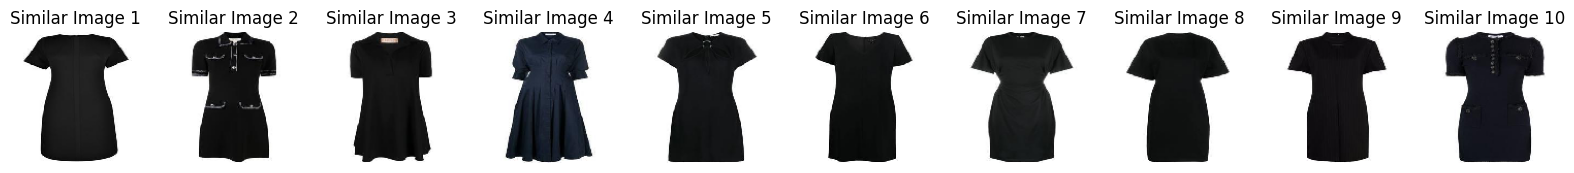

In [ ]:
# Пример использования функции
image_path = '/content/408.jpg'
find_similar_images(image_path, num_neighbors=10)

20/20 [==============================] - 0s 4ms/step


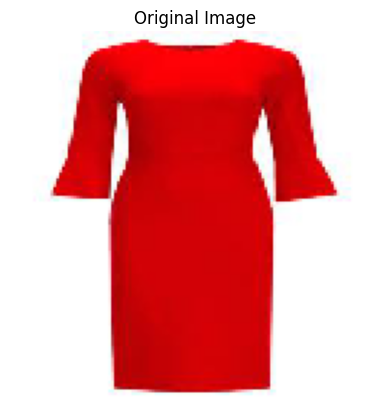

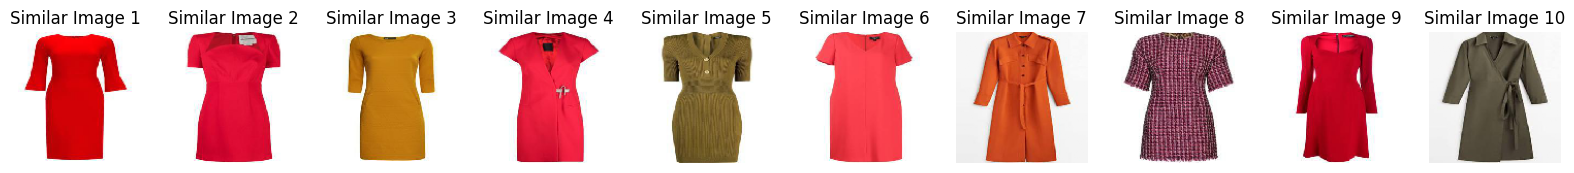

In [ ]:
# Пример использования функции
image_path = '/content/657 (4).jpg'
find_similar_images(image_path, num_neighbors=10)

20/20 [==============================] - 0s 4ms/step


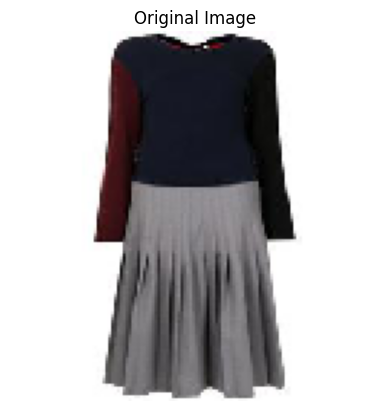

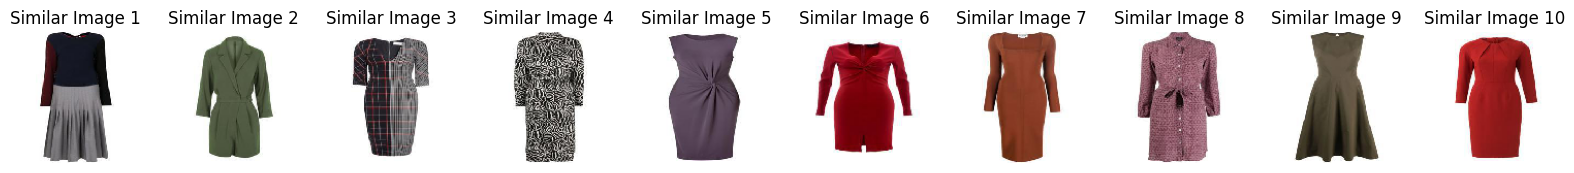

In [ ]:
# Пример использования функции
image_path = '/content/17247234_35368313_1000.jpg'
find_similar_images(image_path, num_neighbors=10)

In [ ]:
# Сохранение весов модели
vae.save_weights("dress_business_веса.h5")

In [ ]:
# Сохранение архитектуры модели на будущее

with open("dress_business_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

In [ ]:
# загрузка модели, чтобы восстановить модель из этих двух файлов выше
from tensorflow.keras.models import model_from_json

# Загрузка архитектуры модели

with open("dress_business_архитектура.json", "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

# Загрузка весов модели
loaded_model.load_weights("dress_business_веса.h5")

In [ ]:
# сохраняем файлы на Google Диск

import shutil
shutil.copy('dress_business_веса.h5', '/content/gdrive/MyDrive/dress_business_веса.h5')
shutil.copy('dress_business_архитектура.json', '/content/gdrive/MyDrive/dress_business_архитектура.json')

'/content/gdrive/MyDrive/dress_business_архитектура.json'

# **dress casual**

In [ ]:
# Создание списка категорий товаров
categories = ['dress casual'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_2 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_2.append(image)

# Преобразование списка в массив
X_2 = np.array(X_2)

# Нормализация данных
X_2 = X_2.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_2, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

In [ ]:
# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

Epoch 1/50
20/20 [==============================] - 1s 43ms/step - loss: 0.6407 - val_loss: 0.2209
Epoch 2/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0657 - val_loss: 0.0400
Epoch 3/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0407 - val_loss: 0.0357
Epoch 4/50
20/20 [==============================] - 1s 35ms/step - loss: 0.0383 - val_loss: 0.0349
Epoch 5/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0375 - val_loss: 0.0343
Epoch 6/50
20/20 [==============================] - 1s 38ms/step - loss: 0.0370 - val_loss: 0.0341
Epoch 7/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0365 - val_loss: 0.0340
Epoch 8/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0363 - val_loss: 0.0338
Epoch 9/50
20/20 [==============================] - 1s 42ms/step - loss: 0.0361 - val_loss: 0.0339
Epoch 10/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0359 - val_loss: 0.0336
Epoch 11/

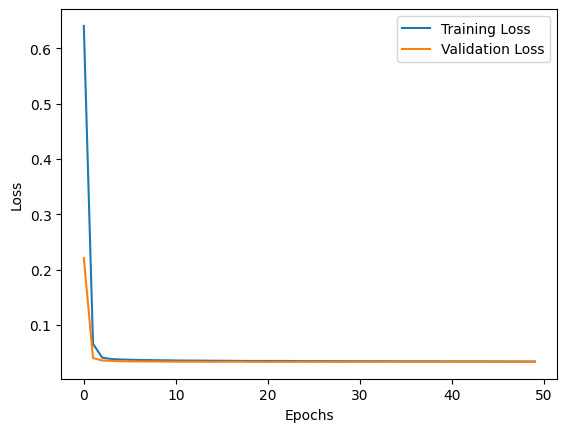

In [ ]:
# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Сохранение весов модели
vae.save_weights("dress_casual_веса.h5")

# Сохранение архитектуры модели на будущее

with open("dress_casual_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('dress_casual_веса.h5', '/content/gdrive/MyDrive/dress_casual_веса.h5')
shutil.copy('dress_casual_архитектура.json', '/content/gdrive/MyDrive/dress_casual_архитектура.json')

'/content/gdrive/MyDrive/dress_casual_архитектура.json'

# **dress homemade**

Epoch 1/50
24/24 [==============================] - 2s 68ms/step - loss: 0.0334 - val_loss: 0.0305
Epoch 2/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0306 - val_loss: 0.0289
Epoch 3/50
24/24 [==============================] - 1s 43ms/step - loss: 0.0300 - val_loss: 0.0286
Epoch 4/50
24/24 [==============================] - 1s 45ms/step - loss: 0.0297 - val_loss: 0.0287
Epoch 5/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0300 - val_loss: 0.0284
Epoch 6/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0297 - val_loss: 0.0284
Epoch 7/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0294 - val_loss: 0.0282
Epoch 8/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0296 - val_loss: 0.0282
Epoch 9/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0293 - val_loss: 0.0285
Epoch 10/50
24/24 [==============================] - 1s 38ms/step - loss: 0.0294 - val_loss: 0.0282
Epoch 11/

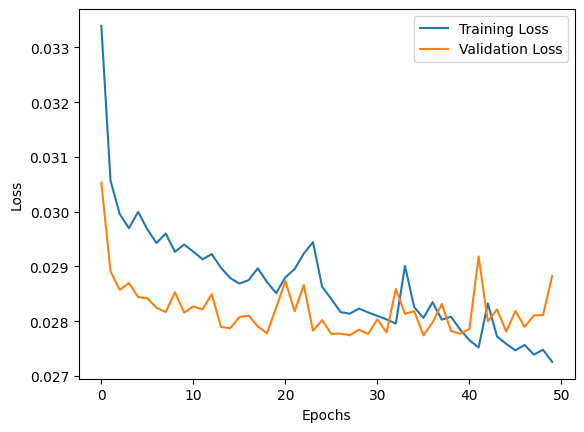

'/content/gdrive/MyDrive/dress_homemade_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['dress homemade'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_3 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_3.append(image)

# Преобразование списка в массив
X_3 = np.array(X_3)

# Нормализация данных
X_3 = X_3.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_3, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("dress_homemade_веса.h5")

# Сохранение архитектуры модели на будущее
with open("dress_homemade_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('dress_homemade_веса.h5', '/content/gdrive/MyDrive/dress_homemade_веса.h5')
shutil.copy('dress_homemade_архитектура.json', '/content/gdrive/MyDrive/dress_homemade_архитектура.json')

# **dress solemn**

Epoch 1/50
21/21 [==============================] - 2s 81ms/step - loss: 0.0492 - val_loss: 0.0402
Epoch 2/50
21/21 [==============================] - 1s 39ms/step - loss: 0.0421 - val_loss: 0.0377
Epoch 3/50
21/21 [==============================] - 1s 39ms/step - loss: 0.0398 - val_loss: 0.0366
Epoch 4/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0391 - val_loss: 0.0370
Epoch 5/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0386 - val_loss: 0.0361
Epoch 6/50
21/21 [==============================] - 1s 40ms/step - loss: 0.0380 - val_loss: 0.0360
Epoch 7/50
21/21 [==============================] - 1s 40ms/step - loss: 0.0379 - val_loss: 0.0368
Epoch 8/50
21/21 [==============================] - 1s 41ms/step - loss: 0.0377 - val_loss: 0.0356
Epoch 9/50
21/21 [==============================] - 1s 39ms/step - loss: 0.0373 - val_loss: 0.0361
Epoch 10/50
21/21 [==============================] - 1s 41ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 11/

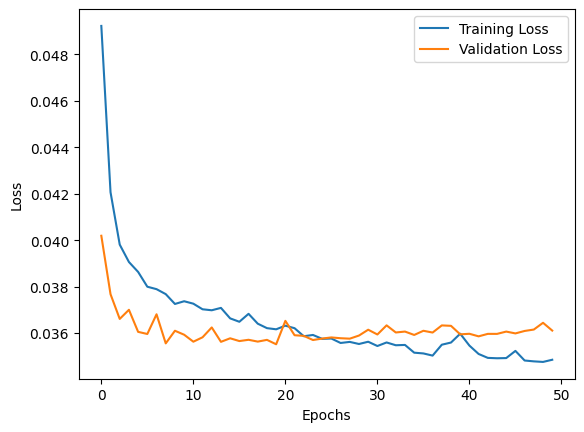

'/content/gdrive/MyDrive/dress_solemn_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['dress solemn'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_4 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_4.append(image)

# Преобразование списка в массив
X_4 = np.array(X_4)

# Нормализация данных
X_4 = X_4.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_4, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("dress_solemn_веса.h5")

# Сохранение архитектуры модели на будущее
with open("dress_solemn_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('dress_solemn_веса.h5', '/content/gdrive/MyDrive/dress_solemn_веса.h5')
shutil.copy('dress_solemn_архитектура.json', '/content/gdrive/MyDrive/dress_solemn_архитектура.json')

# **shirt men**

Epoch 1/50
50/50 [==============================] - 2s 44ms/step - loss: 0.0482 - val_loss: 0.0421
Epoch 2/50
50/50 [==============================] - 2s 37ms/step - loss: 0.0387 - val_loss: 0.0380
Epoch 3/50
50/50 [==============================] - 2s 41ms/step - loss: 0.0365 - val_loss: 0.0373
Epoch 4/50
50/50 [==============================] - 2s 37ms/step - loss: 0.0358 - val_loss: 0.0365
Epoch 5/50
50/50 [==============================] - 2s 38ms/step - loss: 0.0354 - val_loss: 0.0359
Epoch 6/50
50/50 [==============================] - 2s 36ms/step - loss: 0.0350 - val_loss: 0.0354
Epoch 7/50
50/50 [==============================] - 2s 36ms/step - loss: 0.0346 - val_loss: 0.0353
Epoch 8/50
50/50 [==============================] - 2s 37ms/step - loss: 0.0344 - val_loss: 0.0351
Epoch 9/50
50/50 [==============================] - 2s 37ms/step - loss: 0.0344 - val_loss: 0.0349
Epoch 10/50
50/50 [==============================] - 2s 42ms/step - loss: 0.0342 - val_loss: 0.0347
Epoch 11/

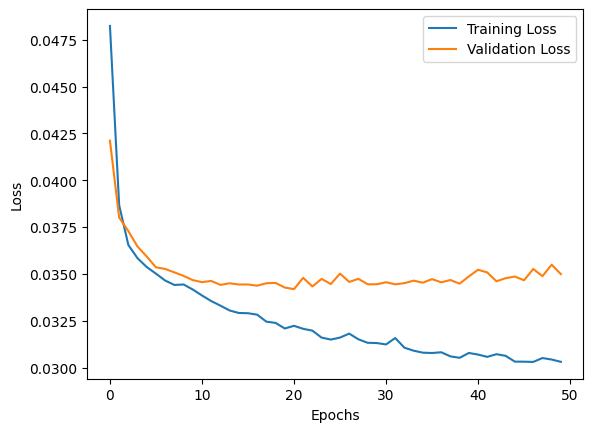

'/content/gdrive/MyDrive/shirt_men_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['shirt men'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_5 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_5.append(image)

# Преобразование списка в массив
X_5 = np.array(X_5)

# Нормализация данных
X_5 = X_5.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_5, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("shirt_men_веса.h5")

# Сохранение архитектуры модели на будущее
with open("shirt_men_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('shirt_men_веса.h5', '/content/gdrive/MyDrive/shirt_men_веса.h5')
shutil.copy('shirt_men_архитектура.json', '/content/gdrive/MyDrive/shirt_men_архитектура.json')

# **shirt women**

In [ ]:
# Создание списка категорий товаров
categories = ['shirt women'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_6 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_6.append(image)

# Преобразование списка в массив
X_6 = np.array(X_6)

# Нормализация данных
X_6 = X_6.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_6, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("shirt_women_веса.h5")

# Сохранение архитектуры модели на будущее
with open("shirt_women_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('shirt_women_веса.h5', '/content/gdrive/MyDrive/shirt_women_веса.h5')
shutil.copy('shirt_women_архитектура.json', '/content/gdrive/MyDrive/shirt_women_архитектура.json')

In [ ]:
# Сохранение весов модели
vae.save_weights("shirt_women_веса.h5")

# Сохранение архитектуры модели на будущее
with open("shirt_women_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('shirt_women_веса.h5', '/content/gdrive/MyDrive/shirt_women_веса.h5')
shutil.copy('shirt_women_архитектура.json', '/content/gdrive/MyDrive/shirt_women_архитектура.json')

'/content/gdrive/MyDrive/shirt_women_архитектура.json'

# **sportswear men**

Epoch 1/50
21/21 [==============================] - 2s 76ms/step - loss: 0.0624 - val_loss: 0.0615
Epoch 2/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0517 - val_loss: 0.0579
Epoch 3/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0498 - val_loss: 0.0572
Epoch 4/50
21/21 [==============================] - 1s 36ms/step - loss: 0.0489 - val_loss: 0.0568
Epoch 5/50
21/21 [==============================] - 1s 44ms/step - loss: 0.0482 - val_loss: 0.0560
Epoch 6/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0477 - val_loss: 0.0565
Epoch 7/50
21/21 [==============================] - 1s 41ms/step - loss: 0.0474 - val_loss: 0.0560
Epoch 8/50
21/21 [==============================] - 1s 39ms/step - loss: 0.0471 - val_loss: 0.0559
Epoch 9/50
21/21 [==============================] - 1s 40ms/step - loss: 0.0469 - val_loss: 0.0554
Epoch 10/50
21/21 [==============================] - 1s 37ms/step - loss: 0.0465 - val_loss: 0.0552
Epoch 11/

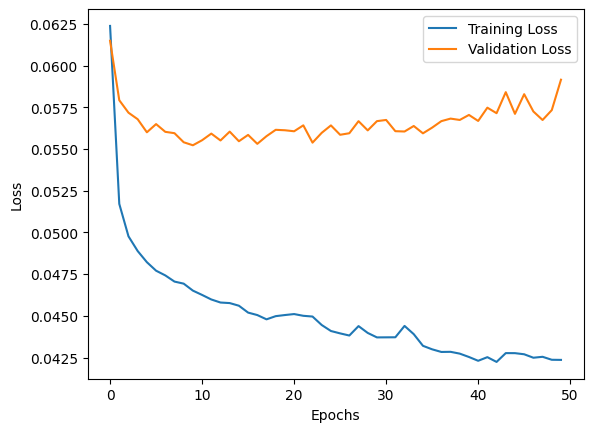

'/content/gdrive/MyDrive/sportswear men_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['sportswear men'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_7 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_7.append(image)

# Преобразование списка в массив
X_7 = np.array(X_7)

# Нормализация данных
X_7 = X_7.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_7, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("sportswear men_веса.h5")

# Сохранение архитектуры модели на будущее
with open("sportswear men_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('sportswear men_веса.h5', '/content/gdrive/MyDrive/sportswear men_веса.h5')
shutil.copy('sportswear men_архитектура.json', '/content/gdrive/MyDrive/sportswear men_архитектура.json')

# **sportswear women**

Epoch 1/50
25/25 [==============================] - 1s 44ms/step - loss: 0.0382 - val_loss: 0.0557
Epoch 2/50
25/25 [==============================] - 1s 35ms/step - loss: 0.0385 - val_loss: 0.0558
Epoch 3/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0389 - val_loss: 0.0541
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0382 - val_loss: 0.0556
Epoch 5/50
25/25 [==============================] - 1s 41ms/step - loss: 0.0377 - val_loss: 0.0556
Epoch 6/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0376 - val_loss: 0.0548
Epoch 7/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0374 - val_loss: 0.0551
Epoch 8/50
25/25 [==============================] - 1s 38ms/step - loss: 0.0372 - val_loss: 0.0550
Epoch 9/50
25/25 [==============================] - 1s 36ms/step - loss: 0.0371 - val_loss: 0.0560
Epoch 10/50
25/25 [==============================] - 1s 36ms/step - loss: 0.0368 - val_loss: 0.0550
Epoch 11/

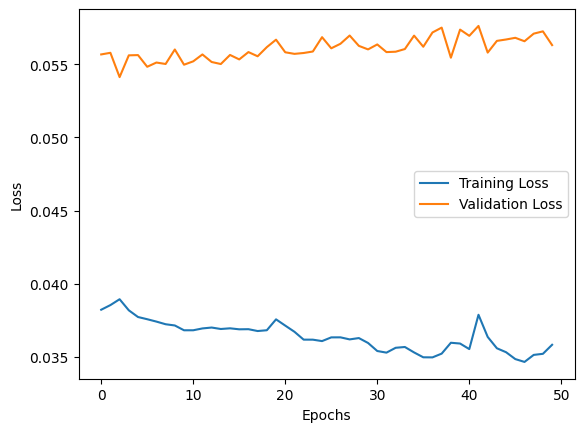

'/content/gdrive/MyDrive/sportswear women_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['sportswear women'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_8 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_8.append(image)

# Преобразование списка в массив
X_8 = np.array(X_8)

# Нормализация данных
X_8 = X_8.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_8, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("sportswear women_веса.h5")

# Сохранение архитектуры модели на будущее
with open("sportswear women_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('sportswear women_веса.h5', '/content/gdrive/MyDrive/sportswear women_веса.h5')
shutil.copy('sportswear women_архитектура.json', '/content/gdrive/MyDrive/sportswear women_архитектура.json')

# **t-shirt men**

Epoch 1/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0409 - val_loss: 0.0320
Epoch 2/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0282 - val_loss: 0.0271
Epoch 3/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0249 - val_loss: 0.0252
Epoch 4/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0238 - val_loss: 0.0245
Epoch 5/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 6/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0223 - val_loss: 0.0235
Epoch 7/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0218 - val_loss: 0.0233
Epoch 8/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 9/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0211 - val_loss: 0.0228
Epoch 10/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0209 - val_loss: 0.0228
Epoch 11/

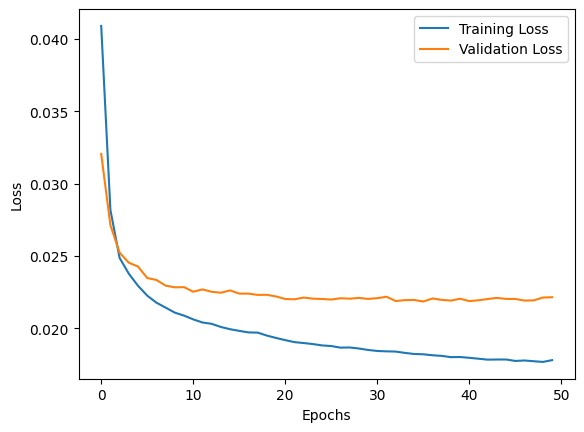

'/content/gdrive/MyDrive/t-shirt men_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['t-shirt men'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_9 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_9.append(image)

# Преобразование списка в массив
X_9 = np.array(X_9)

# Нормализация данных
X_9 = X_9.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_9, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("t-shirt men_веса.h5")

# Сохранение архитектуры модели на будущее
with open("t-shirt men_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('t-shirt men_веса.h5', '/content/gdrive/MyDrive/t-shirt men women_веса.h5')
shutil.copy('t-shirt men_архитектура.json', '/content/gdrive/MyDrive/t-shirt men_архитектура.json')

In [ ]:
# Сохранение весов модели
vae.save_weights("t-shirt men_веса.h5")

# Сохранение архитектуры модели на будущее
with open("t-shirt men_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('t-shirt men_веса.h5', '/content/gdrive/MyDrive/t-shirt men_веса.h5')
shutil.copy('t-shirt men_архитектура.json', '/content/gdrive/MyDrive/t-shirt men_архитектура.json')

'/content/gdrive/MyDrive/t-shirt men_архитектура.json'

# **t-shirt women**

Epoch 1/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0318 - val_loss: 0.0309
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0289 - val_loss: 0.0299
Epoch 3/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0278 - val_loss: 0.0298
Epoch 4/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0271 - val_loss: 0.0290
Epoch 5/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0264 - val_loss: 0.0289
Epoch 6/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0261 - val_loss: 0.0286
Epoch 7/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 8/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0255 - val_loss: 0.0287
Epoch 9/50
30/30 [==============================] - 1s 40ms/step - loss: 0.0253 - val_loss: 0.0292
Epoch 10/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0253 - val_loss: 0.0288
Epoch 11/

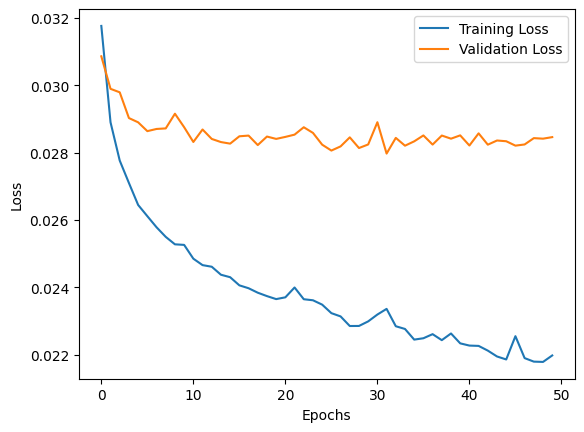

'/content/gdrive/MyDrive/t-shirt women_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['t-shirt women'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_10 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_10.append(image)

# Преобразование списка в массив
X_10 = np.array(X_10)

# Нормализация данных
X_10 = X_10.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_10, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("t-shirt women_веса.h5")

# Сохранение архитектуры модели на будущее
with open("t-shirt women_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('t-shirt women_веса.h5', '/content/gdrive/MyDrive/t-shirt women_веса.h5')
shutil.copy('t-shirt women_архитектура.json', '/content/gdrive/MyDrive/t-shirt women_архитектура.json')

# **trousers men**

Epoch 1/50
34/34 [==============================] - 2s 42ms/step - loss: 0.0399 - val_loss: 0.0303
Epoch 2/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0272 - val_loss: 0.0264
Epoch 3/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 4/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0237 - val_loss: 0.0242
Epoch 5/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0228 - val_loss: 0.0234
Epoch 6/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0224 - val_loss: 0.0233
Epoch 7/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 8/50
34/34 [==============================] - 1s 37ms/step - loss: 0.0216 - val_loss: 0.0226
Epoch 9/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0213 - val_loss: 0.0225
Epoch 10/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0210 - val_loss: 0.0224
Epoch 11/

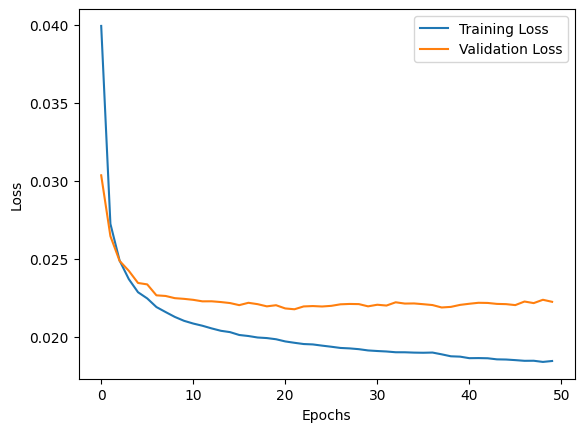

'/content/gdrive/MyDrive/trousers men_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['trousers men'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_11 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_11.append(image)

# Преобразование списка в массив
X_11 = np.array(X_11)

# Нормализация данных
X_11 = X_11.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_11, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("trousers men_веса.h5")

# Сохранение архитектуры модели на будущее
with open("trousers men_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('trousers men_веса.h5', '/content/gdrive/MyDrive/trousers men_веса.h5')
shutil.copy('trousers men_архитектура.json', '/content/gdrive/MyDrive/trousers men_архитектура.json')

# **trousers women**

Epoch 1/50
25/25 [==============================] - 2s 78ms/step - loss: 0.0197 - val_loss: 0.0188
Epoch 2/50
25/25 [==============================] - 1s 36ms/step - loss: 0.0176 - val_loss: 0.0181
Epoch 3/50
25/25 [==============================] - 1s 37ms/step - loss: 0.0167 - val_loss: 0.0182
Epoch 4/50
25/25 [==============================] - 1s 36ms/step - loss: 0.0165 - val_loss: 0.0177
Epoch 5/50
25/25 [==============================] - 1s 38ms/step - loss: 0.0160 - val_loss: 0.0180
Epoch 6/50
25/25 [==============================] - 1s 42ms/step - loss: 0.0157 - val_loss: 0.0173
Epoch 7/50
25/25 [==============================] - 1s 40ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 8/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0151 - val_loss: 0.0171
Epoch 9/50
25/25 [==============================] - 1s 36ms/step - loss: 0.0152 - val_loss: 0.0172
Epoch 10/50
25/25 [==============================] - 1s 39ms/step - loss: 0.0150 - val_loss: 0.0172
Epoch 11/

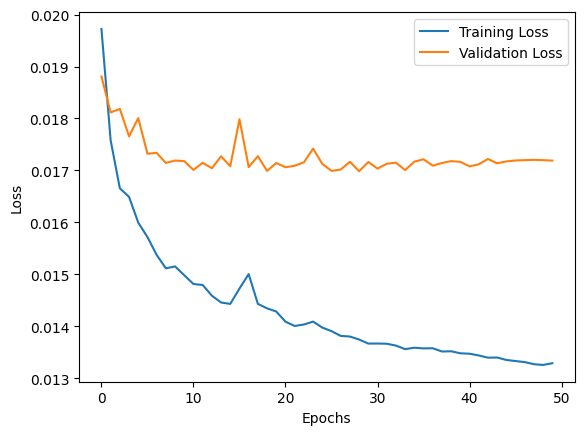

'/content/gdrive/MyDrive/trousers women_архитектура.json'

In [ ]:
# Создание списка категорий товаров
categories = ['trousers women'] # если по всем классам, тогда CLASS_LIST

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(data_dir, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X_12 = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X_12.append(image)

# Преобразование списка в массив
X_12 = np.array(X_12)

# Нормализация данных
X_12 = X_12.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X_12, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Сохранение весов модели
vae.save_weights("trousers women_веса.h5")

# Сохранение архитектуры модели на будущее
with open("trousers women_архитектура.json", "w") as json_file:
    json_file.write(vae.to_json())

# сохраняем файлы на Google Диск

import shutil
shutil.copy('trousers women_веса.h5', '/content/gdrive/MyDrive/trousers women_веса.h5')
shutil.copy('trousers women_архитектура.json', '/content/gdrive/MyDrive/trousers women_архитектура.json')

# **ОТДЕЛЬНО ЗАГРУЖАЮ НЕЙРОНКУ ПО КЛАССИФИКАЦИИ ТИПА ОДЕЖДЫ (СОЗДАНА и ОБУЧЕНА на ЭТОЙ БАЗЕ В ДРУГОМ НОУТБУКЕ https://colab.research.google.com/drive/1SugFVwE3XQcvLK1HcfMHrDawvpDRY4jm?usp=sharing )**

In [ ]:
# # загрузка модели, чтобы восстановить модель из этих двух файлов веса.h5 и архитектура.json
from tensorflow.keras.models import model_from_json

# Загрузка архитектуры модели

with open("/content/gdrive/MyDrive/архитектура.json", "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model_klasif = model_from_json(loaded_model_json)

# Загрузка весов модели
loaded_model_klasif.load_weights("/content/gdrive/MyDrive/веса.h5")

In [ ]:
# на основании возможных условий по сочетанию типа одежды и архитектура+веса по вариационному автокодировщику составляем словарь
conditions = {
    'dress business': ['dress_business_архитектура.json', 'dress_business_веса.h5'],
    'dress casual': ['dress_casual_архитектура.json', 'dress_casual_веса.h5'],
    'dress homemade': ['dress_homemade_архитектура.json', 'dress_homemade_веса.h5'],
    'dress solemn': ['dress_solemn_архитектура.json', 'dress_solemn_веса.h5'],
    'shirt men': ['shirt_men_архитектура.json', 'shirt_men_веса.h5'],
    'shirt women': ['shirt_women_архитектура.json', 'shirt_women_веса.h5'],
    'sportswear men': ['sportswear_men_архитектура.json', 'sportswear_men_веса.h5'],
    'sportswear women': ['sportswear_women_архитектура.json', 'sportswear_women_веса.h5'],
    't-shirt men': ['t-shirt_men_архитектура.json', 't-shirt_men_веса.h5'],
    't-shirt women': ['t-shirt_women_архитектура.json', 't-shirt_women_веса.h5'],
    'trousers men': ['trousers_men_архитектура.json', 'trousers_men_веса.h5'],
    'trousers women': ['trousers_women_архитектура.json', 'trousers_women_веса.h5'],
}

# **ПРИМЕРЫ ПОДОБРАТЬ ПО ЗАГРУЖАЕМОМУ ФОТО НЕСКОЛЬКО ПОХОЖИХ АРТИКУЛОВ ИЗ БАЗЫ ЗАКАЗЧИКА**

In [ ]:
# Для работы модуль gc (garbage collector) для работы с сборщиком мусор
import gc

# Слой подготовки данных для vgg16(у каждой модели свой)
preprocess_input = tf.keras.applications.vgg16.preprocess_input # обрабатывает входные изображения в соответствии с требованиями модели VGG16
gc.collect() # Вызывается метод collect() сборщика мусора для очистки неиспользуемой памяти

2333

# **ПРИМЕР №1**

In [ ]:
image_path = "/content/17247234_35368313_1000.jpg"
image = Image.open(image_path)
image = image.resize((244, 244))

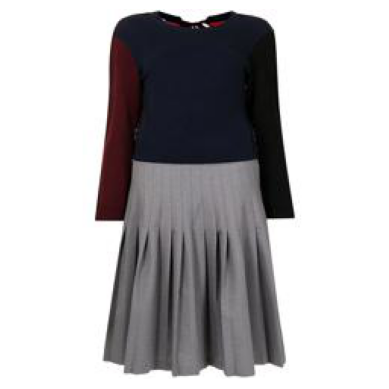

In [ ]:
# показываем загруженое фото
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Преобразуйте изображение в массив numpy и выполните предварительную обработку, аналогичную той, которую использовали для обучающего набора данных
image_array = np.array(image)
preprocessed_image = preprocess_input(image_array)

In [ ]:
# предсказание для преобразованного изображения с помощью обученной модели.

predictions = loaded_model_klasif.predict(np.expand_dims(preprocessed_image, axis=0))

1/1 [==============================] - 7s 7s/step


In [ ]:
# ализируем результаты предсказания, чтобы определить класс, к которому относится изображение, и соответствующую точность.
class_names = CLASS_LIST
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

Predicted class: dress  business
Confidence: 0.9475527


In [ ]:
updated_predicted_class = re.sub(r'\s{2}', ' ', predicted_class)
result = conditions.get(updated_predicted_class, "нет такого ключа")
print(result)

['dress_business_архитектура.json', 'dress_business_веса.h5']


In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print(file_path)

/content/gdrive/MyDrive/dress_business_веса.h5


In [ ]:
# загрузка модели VAE нужного класса, чтобы восстановить модель из этих двух файлов выше
from tensorflow.keras.models import model_from_json

# Загрузка архитектуры модели
file_path_1 = '/content/gdrive/MyDrive/' + result[0]
with open(file_path_1, "r") as json_file_vae:
    loaded_model_json_vae = json_file_vae.read()
    vae = model_from_json(loaded_model_json_vae)

# Загрузка весов модели
file_path_2 = '/content/gdrive/MyDrive/' + result[1]
vae.load_weights(file_path_2)

20/20 [==============================] - 0s 8ms/step


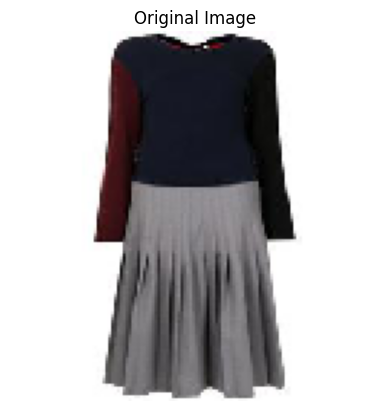

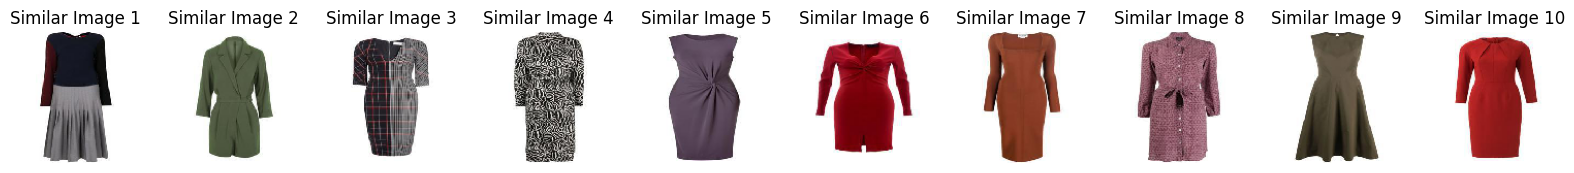

In [ ]:
find_similar_images(image_path, num_neighbors=10)

# **ПРИМЕР №2**

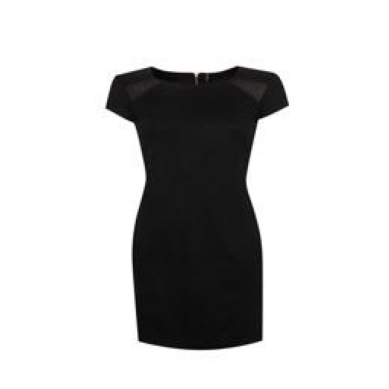

In [ ]:
image_path = "/content/28.jpg"
image = Image.open(image_path)
image = image.resize((244, 244))

# показываем загруженое фото
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Преобразуйте изображение в массив numpy и выполните предварительную обработку, аналогичную той, которую использовали для обучающего набора данных
image_array = np.array(image)
preprocessed_image = preprocess_input(image_array)

# предсказание для преобразованного изображения с помощью обученной модели.
predictions = loaded_model_klasif.predict(np.expand_dims(preprocessed_image, axis=0))

# ализируем результаты предсказания, чтобы определить класс, к которому относится изображение, и соответствующую точность.
class_names = CLASS_LIST
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

1/1 [==============================] - 0s 22ms/step
Predicted class: dress  business
Confidence: 0.87330073


In [ ]:
updated_predicted_class = re.sub(r'\s{2}', ' ', predicted_class)
result = conditions.get(updated_predicted_class, "нет такого ключа")
print(result)

['dress_business_архитектура.json', 'dress_business_веса.h5']


In [ ]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# загрузка модели VAE нужного класса, чтобы восстановить модель из этих двух файлов выше
from tensorflow.keras.models import model_from_json

# Загрузка архитектуры модели
file_path_1 = '/content/gdrive/MyDrive/' + result[0]
with open(file_path_1, "r") as json_file_vae:
    loaded_model_json_vae = json_file_vae.read()
    vae = model_from_json(loaded_model_json_vae)

# Загрузка весов модели
file_path_2 = '/content/gdrive/MyDrive/' + result[1]
vae.load_weights(file_path_2)

In [ ]:
file_path_1

'/content/gdrive/MyDrive/dress_business_архитектура.json'

20/20 [==============================] - 0s 4ms/step


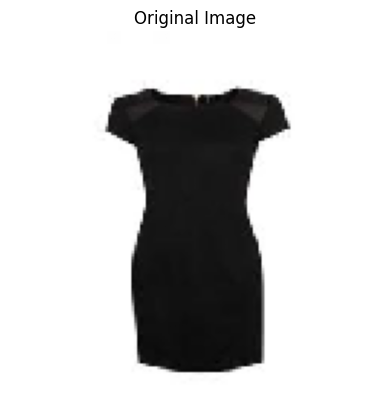

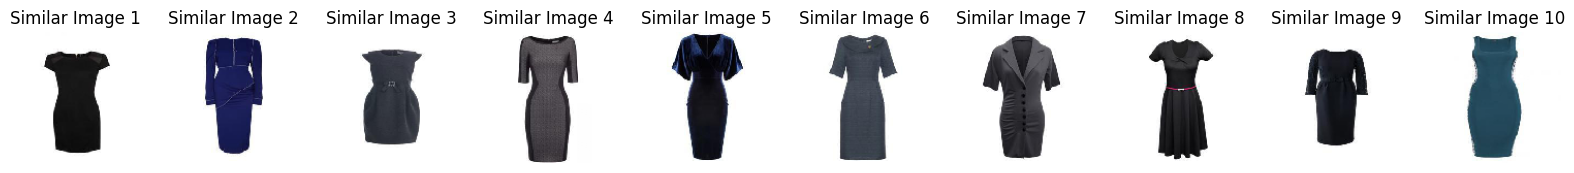

In [ ]:
find_similar_images(image_path, num_neighbors=10)